In [23]:
from sklearn.datasets import fetch_california_housing

In [24]:
x, y = fetch_california_housing(return_X_y=True, as_frame=True)

In [25]:
x.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [26]:
x.info()

<class 'pandas.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


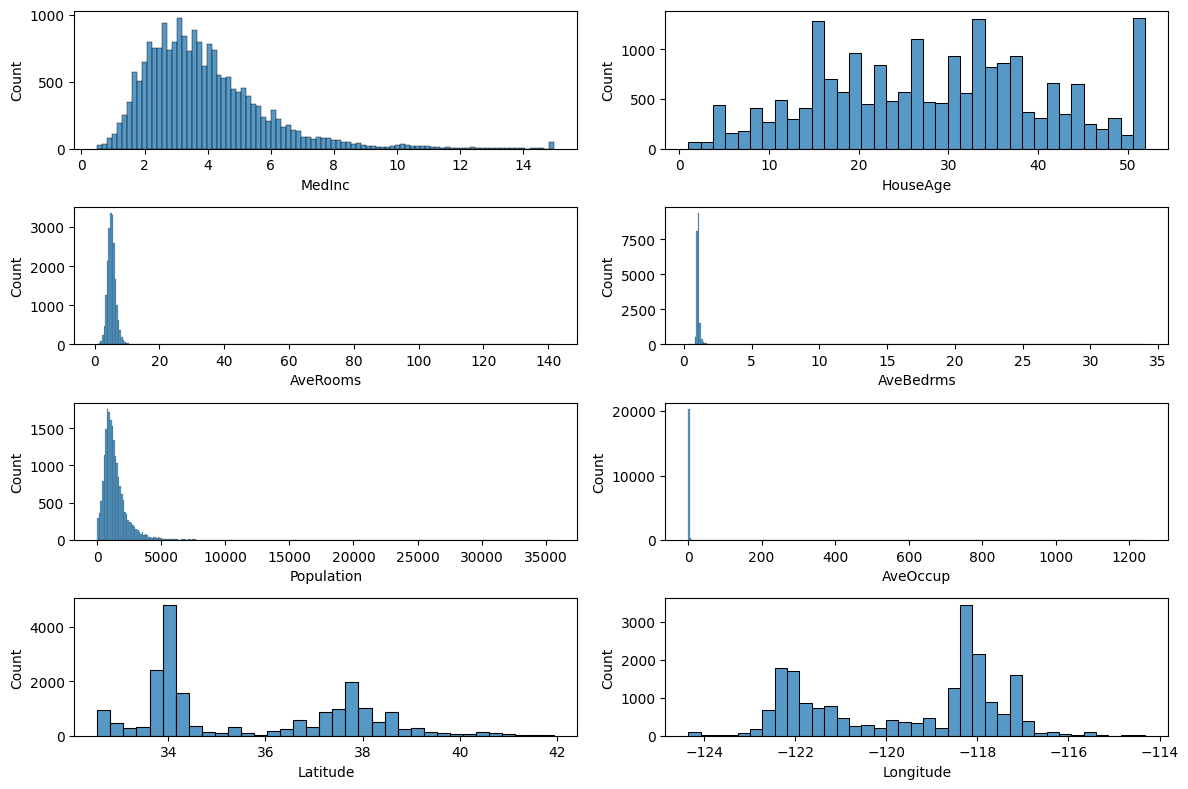

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(4, 2, figsize=(12,8))

for ax, col in zip(ax.ravel(), x.columns):
    sns.histplot(x[col], ax=ax)

fig.tight_layout()

<Axes: xlabel='Longitude', ylabel='Latitude'>

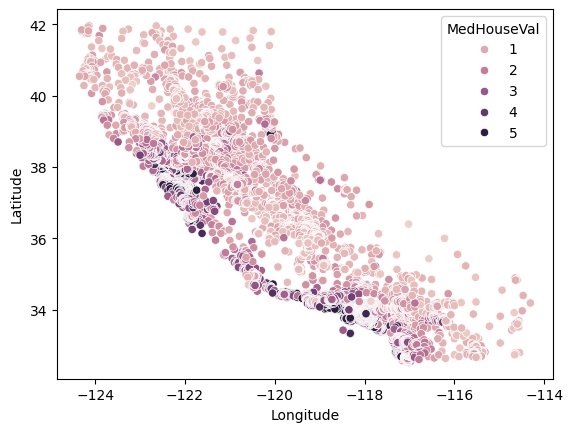

In [28]:
sns.scatterplot(x=x['Longitude'], y=x['Latitude'], hue=y)

<Axes: xlabel='MedHouseVal', ylabel='Count'>

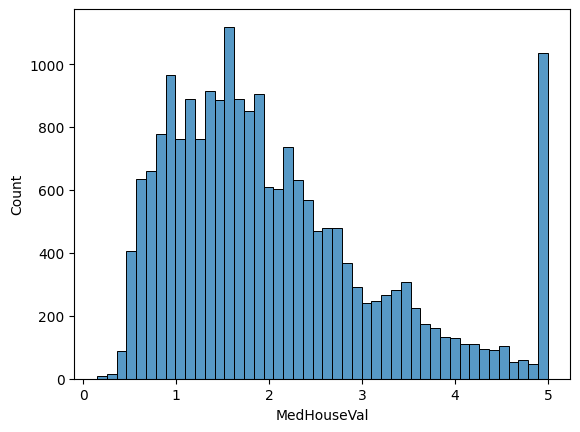

In [29]:
sns.histplot(y)

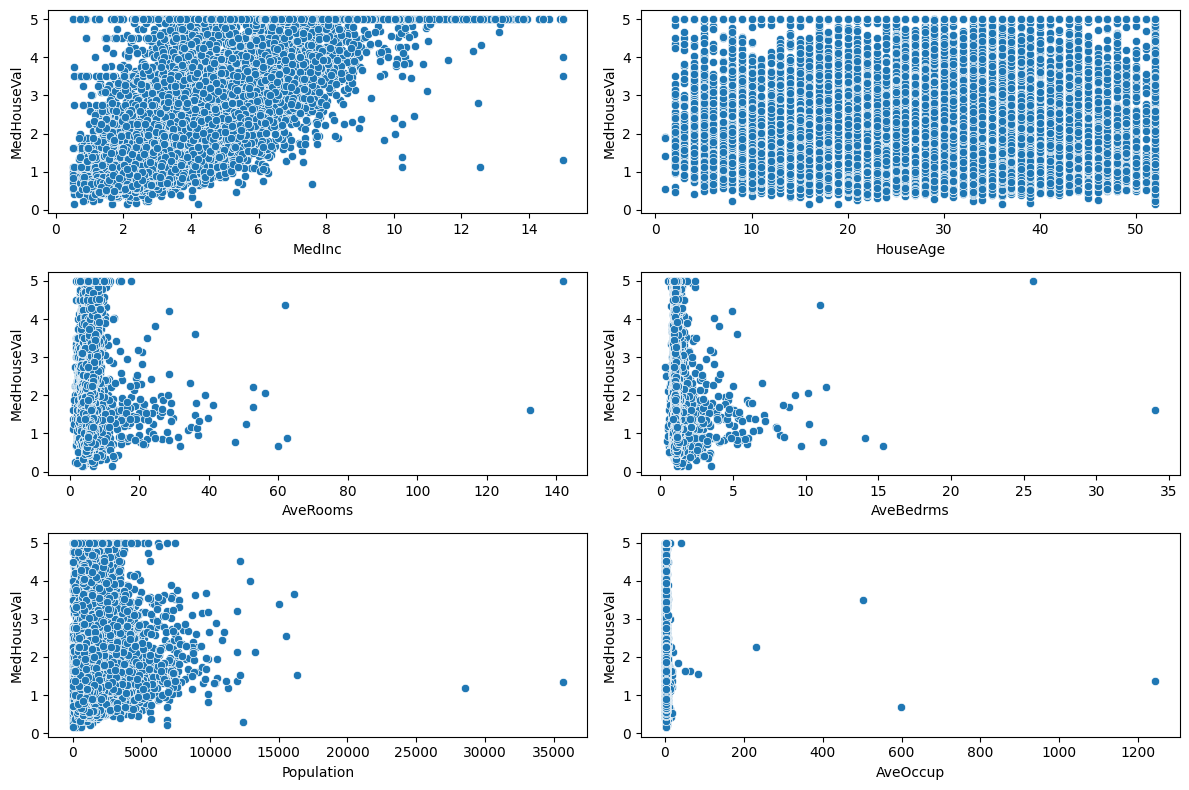

In [30]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']

for ax, col in zip(axs.ravel(), cols):
    sns.scatterplot(x=x[col], y=y, ax=ax)

fig.tight_layout()

In [31]:
from sklearn.model_selection import train_test_split

x_train, x_testval, y_train, y_testval = train_test_split(x, y, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_testval, y_testval, test_size=0.5, random_state=42)

In [32]:
# Use IQR to cap outliers
Q1 = x_train.quantile(0.25)
Q3 = x_train.quantile(0.75)
IQR = Q3 - Q1

x_train_capped = x_train.copy()
x_test_capped = x_test.copy()
x_val_capped = x_val.copy()
for col in x_train.columns:
    lower_bound = Q1[col] - 1.5 * IQR[col]
    upper_bound = Q3[col] + 1.5 * IQR[col]
    x_train_capped[col] = x_train[col].clip(lower=lower_bound, upper=upper_bound)
    x_test_capped[col] = x_test[col].clip(lower=lower_bound, upper=upper_bound)
    x_val_capped[col] = x_val[col].clip(lower=lower_bound, upper=upper_bound)

x_train = x_train_capped
x_test = x_test_capped
x_val = x_val_capped

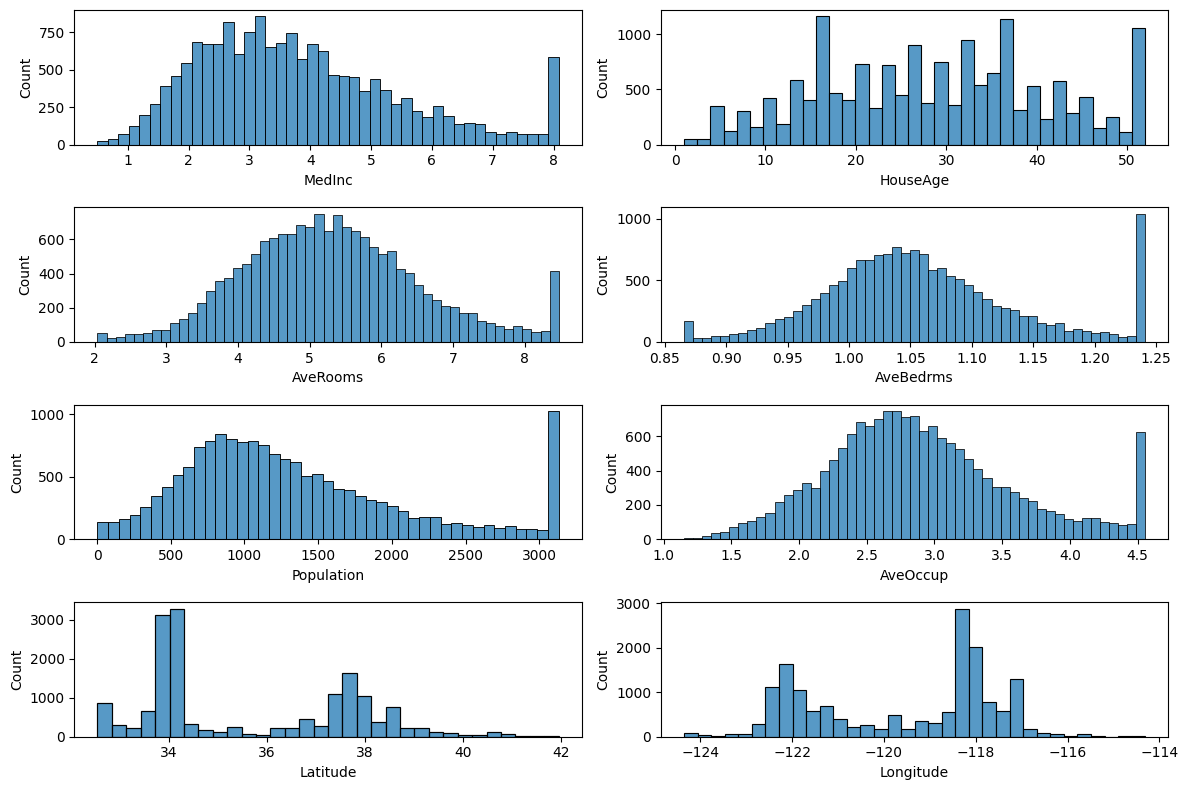

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(4, 2, figsize=(12,8))

for ax, col in zip(ax.ravel(), x.columns):
    sns.histplot(x_train[col], ax=ax)

fig.tight_layout()

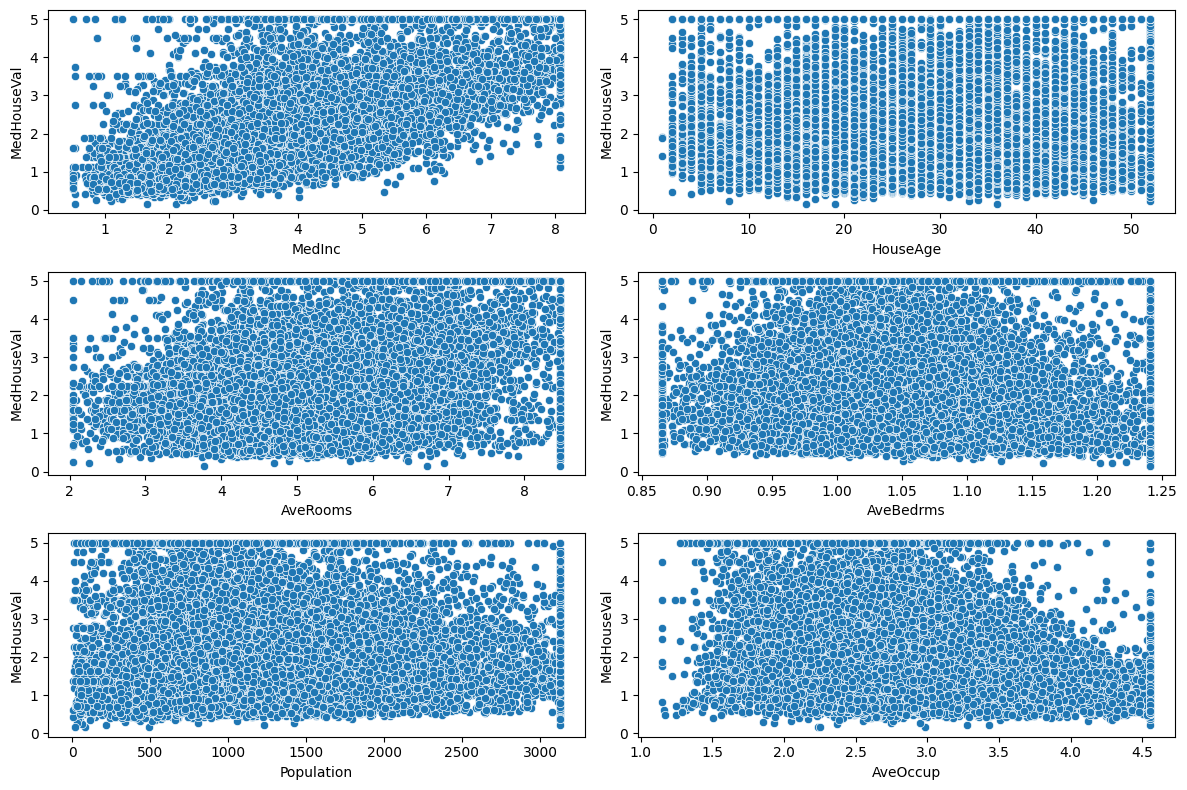

In [34]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']

for ax, col in zip(axs.ravel(), cols):
    sns.scatterplot(x=x_train[col], y=y, ax=ax)

fig.tight_layout()

In [35]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

preprocessing = make_pipeline(
    ColumnTransformer([
        ('min', MinMaxScaler(), x_train.columns)
    ])
)

In [36]:
x_train_processed = preprocessing.fit_transform(x_train)
x_test_processed = preprocessing.transform(x_test)
x_val_processed = preprocessing.transform(x_val)

<Axes: ylabel='Count'>

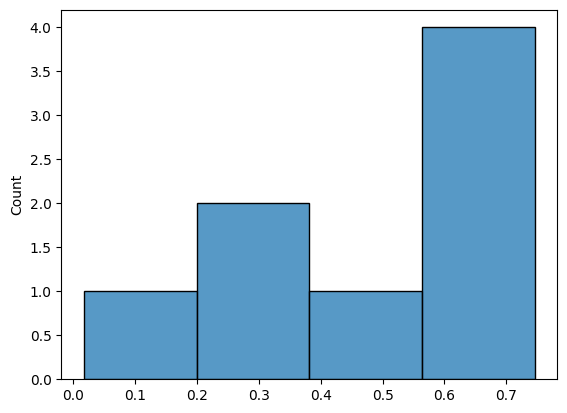

In [42]:
sns.histplot(x_train_processed[0])

# Training and evaluation

We will create a Linear Regression model and evaluate it using different metrics.
Our main metric will be the Root Mean Squared Error (RMSE).

In [46]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(x_train_processed, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import numpy as np
import pandas as pd

def eval(model, x, y):
    y_pred = model.predict(x)
    mse = mean_squared_error(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

train_metrics = eval(model, x_train_processed, y_train)
val_metrics = eval(model, x_val_processed, y_val)

metrics_df = pd.DataFrame([train_metrics, val_metrics], index=['Train', 'Validation'])
metrics_df

,MAE,MSE,RMSE,R2
Train,0.492680,0.437935,0.661767,0.672395
Validation,0.502495,0.452564,0.672729,0.652773


In [63]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()

model.fit(x_train_processed, y_train)

_train_metrics = eval(model, x_train_processed, y_train)
_val_metrics = eval(model, x_val_processed, y_val)

_metrics_df = pd.DataFrame([_train_metrics, _val_metrics], index=['Train', 'Validation'])
_metrics_df

,MAE,MSE,RMSE,R2
Train,0.123678,0.036424,0.190851,0.972752
Validation,0.329366,0.257665,0.507607,0.802309


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

grid_search.fit(x_train_processed, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestRegressor()
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [None, 10, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [10, 20, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the 

In [67]:
bset_model = grid_search.best_estimator_

train_metrics = eval(bset_model, x_train_processed, y_train)
val_metrics = eval(bset_model, x_val_processed, y_val)
test_metrics = eval(bset_model, x_test_processed, y_test)

metrics_df = pd.DataFrame([train_metrics, val_metrics, test_metrics], index=['Train', 'Validation', 'Test'])
metrics_df

,MAE,MSE,RMSE,R2
Train,0.142771,0.050334,0.224352,0.962347
Validation,0.331103,0.260087,0.509987,0.800450
Test,0.329013,0.249734,0.499733,0.810343


In [68]:
grid_search.best_params_

{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}